In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt

import sys
sys.path.append('../../code/lib')

import lif_utils
import numpy as np
import scipy.optimize

In [60]:
np.random.seed(48988)

# Generate some random post-population encoders
N_post = 31
N_pre = 32
d_pre = 3
d_post = 3
E_post= np.random.normal(0, 1, (N_post, d_post))
E_post /= np.linalg.norm(E_post, axis=1)[:, None]
E_pre= np.random.normal(0, 1, (N_pre, d_pre))
E_pre /= np.linalg.norm(E_pre, axis=1)[:, None]

In [61]:
# Generate some pre-population tuning curves
max_rates = np.random.uniform(50, 100, N_pre)
x_intercepts = np.random.uniform(-0.95, 0.95, N_pre)

J1 = lif_utils.lif_rate_inv(max_rates)
J0 = lif_utils.lif_rate_inv(1e-3)

gains = (J1 - J0) / (1 - x_intercepts)
biases =  (J0 - x_intercepts * J1) / (1 - x_intercepts)

In [62]:
# Generate some samples
N_smpls = 1000
xs = np.random.normal(0, 1, (N_smpls, d_pre))
xs /= np.linalg.norm(xs, axis=1)[:, None]
xs *= np.power(np.random.uniform(0, 1, N_smpls)[:, None], 1 / d_pre)
Js = gains[None, :] * (xs @ E_pre.T) + biases[None, :]
As = lif_utils.lif_rate(Js)

In [63]:
T = np.eye(d_post)

In [64]:
# Compute the decoders for some random transformation
ys = xs @ T.T

def loss_l1(D, σ=1):
    D = D.reshape(d_post, N_pre)
    return np.sum(np.square(ys - As @ D.T)) + np.square(σ) * N_smpls * np.sum(np.abs(D))

def loss_l2(D, σ=1):
    D = D.reshape(d_post, N_pre)
    return np.sum(np.square(ys - As @ D.T)) + np.square(σ) * N_smpls * np.sum(np.square(D))

D0 = np.random.randn(d_post, N_pre)
D_L1 = scipy.optimize.minimize(loss_l1, x0=D0.flatten()).x.reshape(d_post, N_pre)
D_L2 = scipy.optimize.minimize(loss_l2, x0=D0.flatten()).x.reshape(d_post, N_pre)

In [65]:
# Solve for non-negative weights, assuming that approx. the last ten pre-neurons are inhibitory
N_inh = int(0.3 * N_pre)
N0, N1, N2 = 0, N_pre - N_inh, N_pre
W_dale = np.zeros((N_post, N_pre))
J_tar = ys @ E_post.T
As_signed = np.concatenate((As[:, N0:N1], -As[:, N1:N2]), axis=1)
σ = 0.1
for i in range(N_post):
    W_dale[i] = scipy.optimize.nnls(
        As_signed.T @ As_signed + N_smpls * np.square(σ) * np.eye(N_pre),
        As_signed.T @ J_tar[:, i]
    )[0]
W_dale[:, N1:N2] *= -1

In [66]:
np.sqrt(np.mean(np.square(ys - As @ D_L1.T))),\
np.sqrt(np.mean(np.square(ys - As @ D_L2.T))),\
np.sqrt(np.mean(np.square(J_tar - As @ W_dale.T))),

(0.07603926310715028, 0.037696008748609566, 0.0817087334840376)

In [67]:
def plot_weight_matrix(E, D):
    fig, axs = plt.subplots(2, 2, figsize=(5, 5), gridspec_kw={
        "width_ratios": [1, 12],
        "height_ratios": [1, 12],
        "hspace": 0.1,
        "wspace": 0.1,
    })

    for spine in ["left", "right", "top", "bottom"]:
        axs[0, 0].spines[spine].set_visible(False)
    axs[0, 0].set_xticks([])
    axs[0, 0].set_yticks([])

    axs[1, 0].imshow(E / np.percentile(np.abs(E), 95), cmap='RdBu', vmin=-1, vmax=1)
    axs[1, 0].set_aspect('auto')
    axs[1, 0].set_yticklabels([])
    axs[1, 0].set_xticks([])
    axs[1, 0].yaxis.tick_right()
    axs[1, 0].set_ylabel("Encoder $\\mathbf{E}$")

    axs[0, 1].imshow(D / np.percentile(np.abs(D), 95), cmap='RdBu', vmin=-1, vmax=1)
    axs[0, 1].set_aspect('auto')
    axs[0, 1].set_xticklabels([])
    axs[0, 1].set_yticks([])
    axs[0, 1].set_title("Decoder $\\mathbf{D}$")

    W = E @ D
    axs[1, 1].imshow(W / np.percentile(np.abs(W), 95), cmap='RdBu', vmin=-1, vmax=1)
    axs[1, 1].set_aspect('auto')
    axs[1, 1].set_xlabel("Pre-neuron index $j$")
    axs[1, 1].yaxis.tick_right()
    axs[1, 1].yaxis.set_label_position("right")
    axs[1, 1].set_ylabel("Post-neuron index $i$")

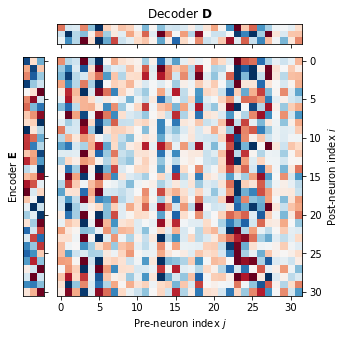

In [68]:
plot_weight_matrix(E_post, D_L2)

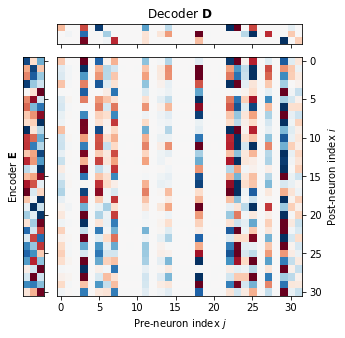

In [69]:
plot_weight_matrix(E_post, D_L1)

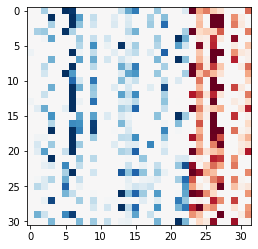

In [70]:
fig, ax = plt.subplots()
ax.imshow(W_dale / np.percentile(np.abs(W_dale), 95), cmap='RdBu', vmin=-1, vmax=1)